In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne
import pickle 
import yaml
from tabulate import tabulate
import pandas as pd

from gaitmod.utils.file_reader import MatFileReader
from gaitmod.utils.data_processor import DataProcessor
from gaitmod.viz import Visualise
from gaitmod.utils.feature_extractor import FeatureExtractor
from gaitmod.utils.utils import *

# Loading the data

In [2]:
config = load_config('gaitmod/configs/data_preprocessing.yaml')

In [3]:
# Handle multiple patients with nested directories.
root_directory = config['data']['root_directory']
subject_id = config['data']['subject_id']
# subject_id = ['PW_HK59']

mat_reader = MatFileReader(root_directory, subject_id)  # adjust the number of workers for parallelism later.

# Read all data from nested folders of multiple patients and sessions
data = mat_reader.read_data(max_workers=10)
n_subjects = len(data)

print(f"Number of subjects: {n_subjects}")

Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_4.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_3.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_6.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_US68/20-12-22/MAT/walking_sync_updated_1.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_US68/20-12-22/MAT/walking_sync_updated_2.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulat

In [4]:
for patient, sessions in data.items():
    print(f"Patient: {patient}, Sessions: {list(sessions.keys())}")

Patient: PW_US68, Sessions: ['walking_sync_updated_3', 'walking_sync_updated_1', 'walking_sync_updated_2']
Patient: PW_HZ58, Sessions: ['walking_sync_updated_6', 'walking_sync_updated_4', 'walking_sync_updated_3']
Patient: PW_FH57, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3', 'walking_sync_updated_4']
Patient: PW_HK59, Sessions: ['walking_sync_updated_3', 'walking_sync_updated_1', 'walking_sync_updated_2']
Patient: PW_SN66, Sessions: ['walking_sync_updated_2', 'walking_sync_updated_1']
Patient: PW_EM59, Sessions: ['walking_sync_updated_3']
Patient: PW_SN61, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3', 'walking_sync_updated_4']


In [5]:
valid_data_types = ['data_acc', 'data_EEG', 'data_EMG', 'data_giro', 'data_LFP']
data_type = 'data_LFP'

try:
    # Pick any subject/session to extract common meta data e.g. the first one
    first_subject = list(data.keys())[0]
    first_session = list(data[first_subject].keys())[0]
    first_data = data[first_subject][first_session]
    if data_type not in valid_data_types:
        raise ValueError("Invalid data type specified.")
except Exception as e:
    raise ValueError(f"Error processing data: {e}")

data_names = ['data_EEG', 'data_EMG', 'data_LFP', 'data_acc', 'data_giro', 'events_KIN', 'events_STEPS', 'filePath_2', 'hdr_EEG', 'hdr_EMG', 'hdr_IMU', 'hdr_LFP', 'pt', 'session']
if not np.all([dt in data_names for dt in first_data.keys()]):
    raise ValueError(f"Invalid data type found in the data.")

# Extract LFP meta data for subject/session
# lfp_metadata = DataProcessor.np_to_dict(first_data['hdr_LFP'])

lfp_metadata = first_data['hdr_LFP']
lfp_sfreq = lfp_metadata['Fs']
lfp_metadata

{'Fs': 250,
 'labels': array(['ZERO_THREE_LEFT', 'ONE_THREE_LEFT', 'ZERO_TWO_LEFT',
        'ZERO_THREE_RIGHT', 'ONE_THREE_RIGHT', 'ZERO_TWO_RIGHT'],
       dtype=object),
 'NumberOfChannels': 6,
 'chanunit': array(['µV', 'µV', 'µV', 'µV', 'µV', 'µV'], dtype='<U2'),
 'chantype': array(['LFP', 'LFP', 'LFP', 'LFP', 'LFP', 'LFP'], dtype='<U3')}

In [6]:
# Process the LFP data
# epochs, events, lfp_raw_list, all_lfp_data = DataProcessor.process_lfp_data()(
#     data, n_sessions, lfp_sfreq, event_of_interest, mod_start_event_id,
#     normal_walking_event_id, gap_sample_length, epoch_sample_length,
#     epoch_tmin, epoch_tmax, epoch_duration, event_dict, info, reject_criteria, config, verbose=False)

In [7]:
fig_save_path ='results/figures/processed_data'
os.makedirs(fig_save_path, exist_ok=True)

fix_chs_names = [
    'ZERO_THREE_LEFT',
    'ONE_THREE_LEFT',
    'ZERO_TWO_LEFT',
    'ZERO_THREE_RIGHT',
    'ONE_THREE_RIGHT',
    'ZERO_TWO_RIGHT']

new_events_order = [
    'trial_start',
    'VA_start_walking',
    'mod_start',
    'VA_cross',
    'min_vel',
    'min_dist',
    'mod_end',
    'trial_stop']

key_map = {"label": "labels",
           "time": "times"}
        
DataProcessor.clean_data(data, 'data_LFP', key_map, new_events_order, lfp_sfreq, fix_chs_names)

subjects_lfp_data_dict, subjects_event_idx_dict = DataProcessor.process_trials_and_events(data, 'data_LFP', lfp_sfreq, config, verbose=True)

ch_names = list(data[first_subject][first_session]['hdr_LFP']['labels'])
ch_names

Patient ID: PW_US68
walking_sync_updated_3: 6 channels found
--------------------------------------------------
walking_sync_updated_1: 6 channels found
--------------------------------------------------
walking_sync_updated_2: 6 channels found
--------------------------------------------------
Patient ID: PW_HZ58
walking_sync_updated_6: 6 channels found
--------------------------------------------------
walking_sync_updated_4: 6 channels found
--------------------------------------------------
walking_sync_updated_3: 6 channels found
--------------------------------------------------
Patient ID: PW_FH57
walking_sync_updated_1: 6 channels found
--------------------------------------------------
walking_sync_updated_2: 6 channels found
--------------------------------------------------
walking_sync_updated_3: 6 channels found
--------------------------------------------------
walking_sync_updated_4: 6 channels found
--------------------------------------------------
Patient ID: PW_HK59


['ZERO_THREE_LEFT',
 'ONE_THREE_LEFT',
 'ZERO_TWO_LEFT',
 'ZERO_THREE_RIGHT',
 'ONE_THREE_RIGHT',
 'ZERO_TWO_RIGHT']

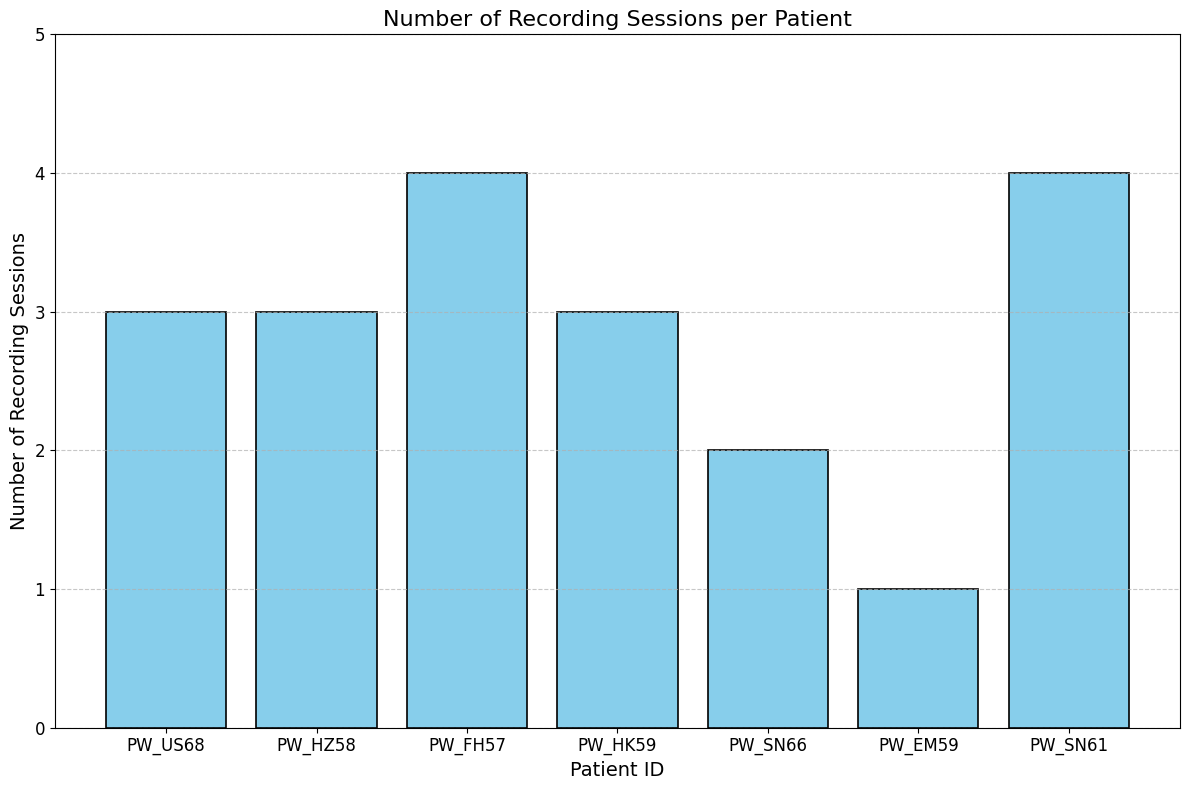

,patient_id,n_essions
0,PW_US68,3
1,PW_HZ58,3
2,PW_FH57,4
3,PW_HK59,3
4,PW_SN66,2
5,PW_EM59,1
6,PW_SN61,4


In [8]:
# Count the number of recording sessions per patient
df_session_counts = pd.DataFrame(
    [(patient, len(sessions)) for patient, sessions in data.items()],
    columns=["patient_id", "n_essions"]
)
# Call the function to plot the session counts
Visualise.plot_session_counts(df_session_counts, fig_save_path, fig_name='session_counts')

df_session_counts

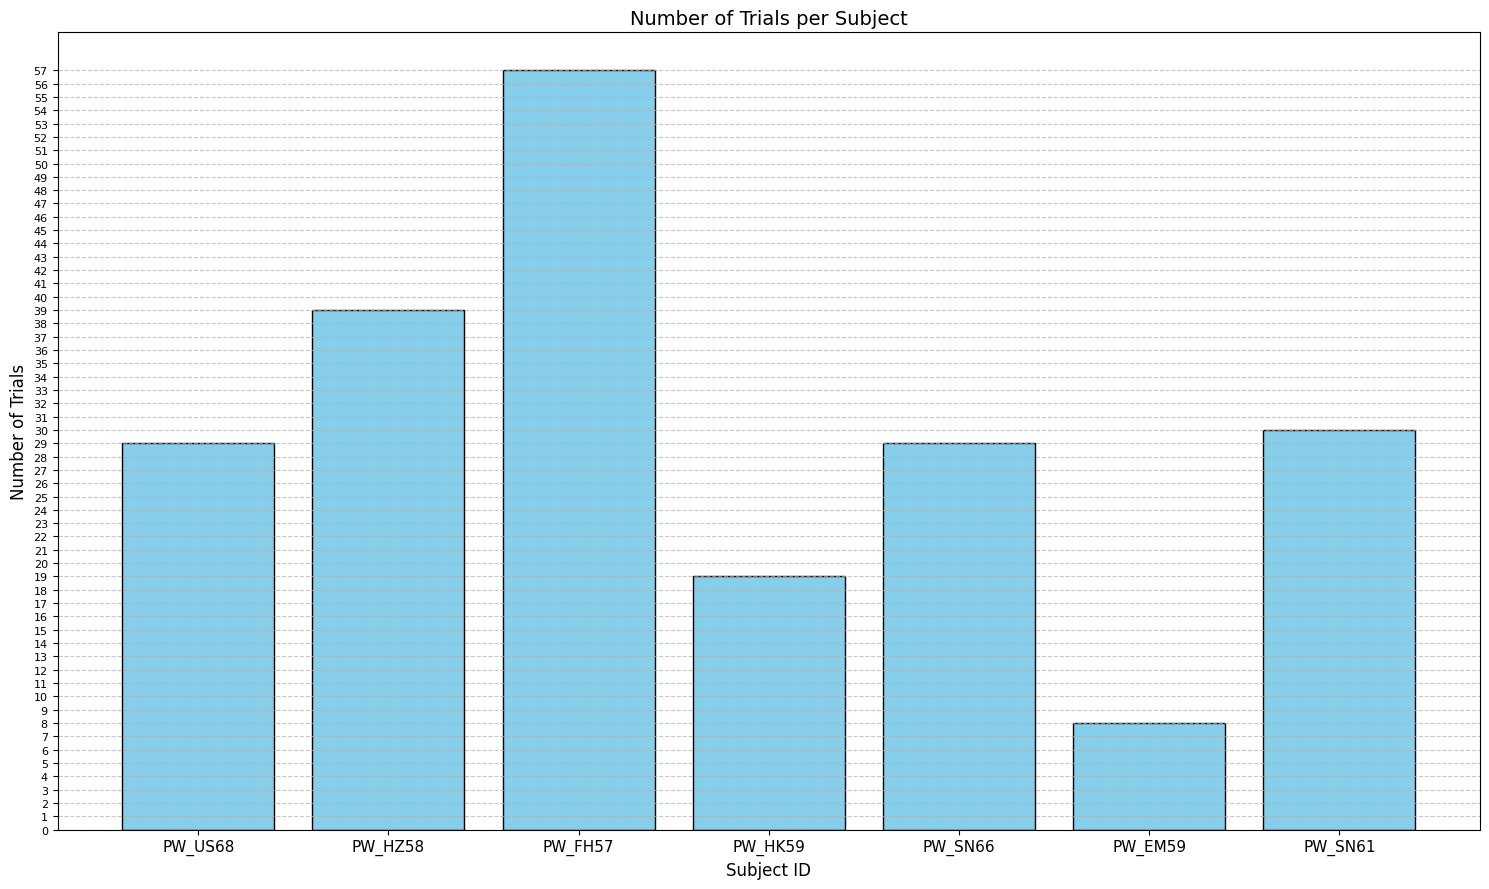

,subject_id,n_trials
0,PW_US68,29
1,PW_HZ58,39
2,PW_FH57,57
3,PW_HK59,19
4,PW_SN66,29
5,PW_EM59,8
6,PW_SN61,30


In [9]:
n_subjects = len(subjects_event_idx_dict)
n_trials_list = []
subjects_list = []

table_data = []
for subject_name, event_data in subjects_event_idx_dict.items():
    n_trials = event_data.shape[0]
    n_trials_list.append(n_trials)
    subjects_list.append(subject_name)
    table_data.append([subject_name, n_trials])
df_trial_counts = pd.DataFrame(table_data, columns=["subject_id", "n_trials"])

Visualise.plot_trial_counts(df_trial_counts, fig_save_path, fig_name='trials_per_subject')

df_trial_counts

In [10]:
min_trial_length = min(
    trial.shape[1]
    for subject_trials in subjects_lfp_data_dict.values()
    for trial in subject_trials
)

max_trial_length = max(
    trial.shape[1]
    for subject_trials in subjects_lfp_data_dict.values()
    for trial in subject_trials
)
print(f"Minimum trial length: {min_trial_length} ({min_trial_length/lfp_sfreq} seconds)")
print(f"Maximum trial length: {max_trial_length } ({max_trial_length/lfp_sfreq} seconds)")

print(f"\n{'-' * 25}\n| Number of subjects: {len(subjects_lfp_data_dict)} |\n{'-' * 25}")
for i, subject_name in enumerate(subjects_lfp_data_dict):
    print(f"\n{i+1}. Subject {subject_name}: Number of trials: {len(subjects_lfp_data_dict[subject_name])}, each with shape (n_channels, n_samples):")
    print("=" * 82)
    for trial_idx in range(len(subjects_lfp_data_dict[subject_name])):
        print(f"{trial_idx+1}. Trial: {subjects_lfp_data_dict[subject_name][trial_idx].shape}")

Minimum trial length: 1050 (4.2 seconds)
Maximum trial length: 7550 (30.2 seconds)

-------------------------
| Number of subjects: 7 |
-------------------------

1. Subject PW_US68: Number of trials: 29, each with shape (n_channels, n_samples):
1. Trial: (6, 1355)
2. Trial: (6, 1630)
3. Trial: (6, 1210)
4. Trial: (6, 1270)
5. Trial: (6, 1225)
6. Trial: (6, 1470)
7. Trial: (6, 1585)
8. Trial: (6, 1800)
9. Trial: (6, 1715)
10. Trial: (6, 1545)
11. Trial: (6, 1375)
12. Trial: (6, 1355)
13. Trial: (6, 1220)
14. Trial: (6, 1625)
15. Trial: (6, 1595)
16. Trial: (6, 1475)
17. Trial: (6, 1690)
18. Trial: (6, 1335)
19. Trial: (6, 1330)
20. Trial: (6, 1410)
21. Trial: (6, 1650)
22. Trial: (6, 1755)
23. Trial: (6, 1670)
24. Trial: (6, 1730)
25. Trial: (6, 1510)
26. Trial: (6, 1270)
27. Trial: (6, 1495)
28. Trial: (6, 1840)
29. Trial: (6, 1475)

2. Subject PW_HZ58: Number of trials: 39, each with shape (n_channels, n_samples):
1. Trial: (6, 1765)
2. Trial: (6, 1720)
3. Trial: (6, 1790)
4. Trial: 

/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gaitmod/gaitmod/viz.py:129: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


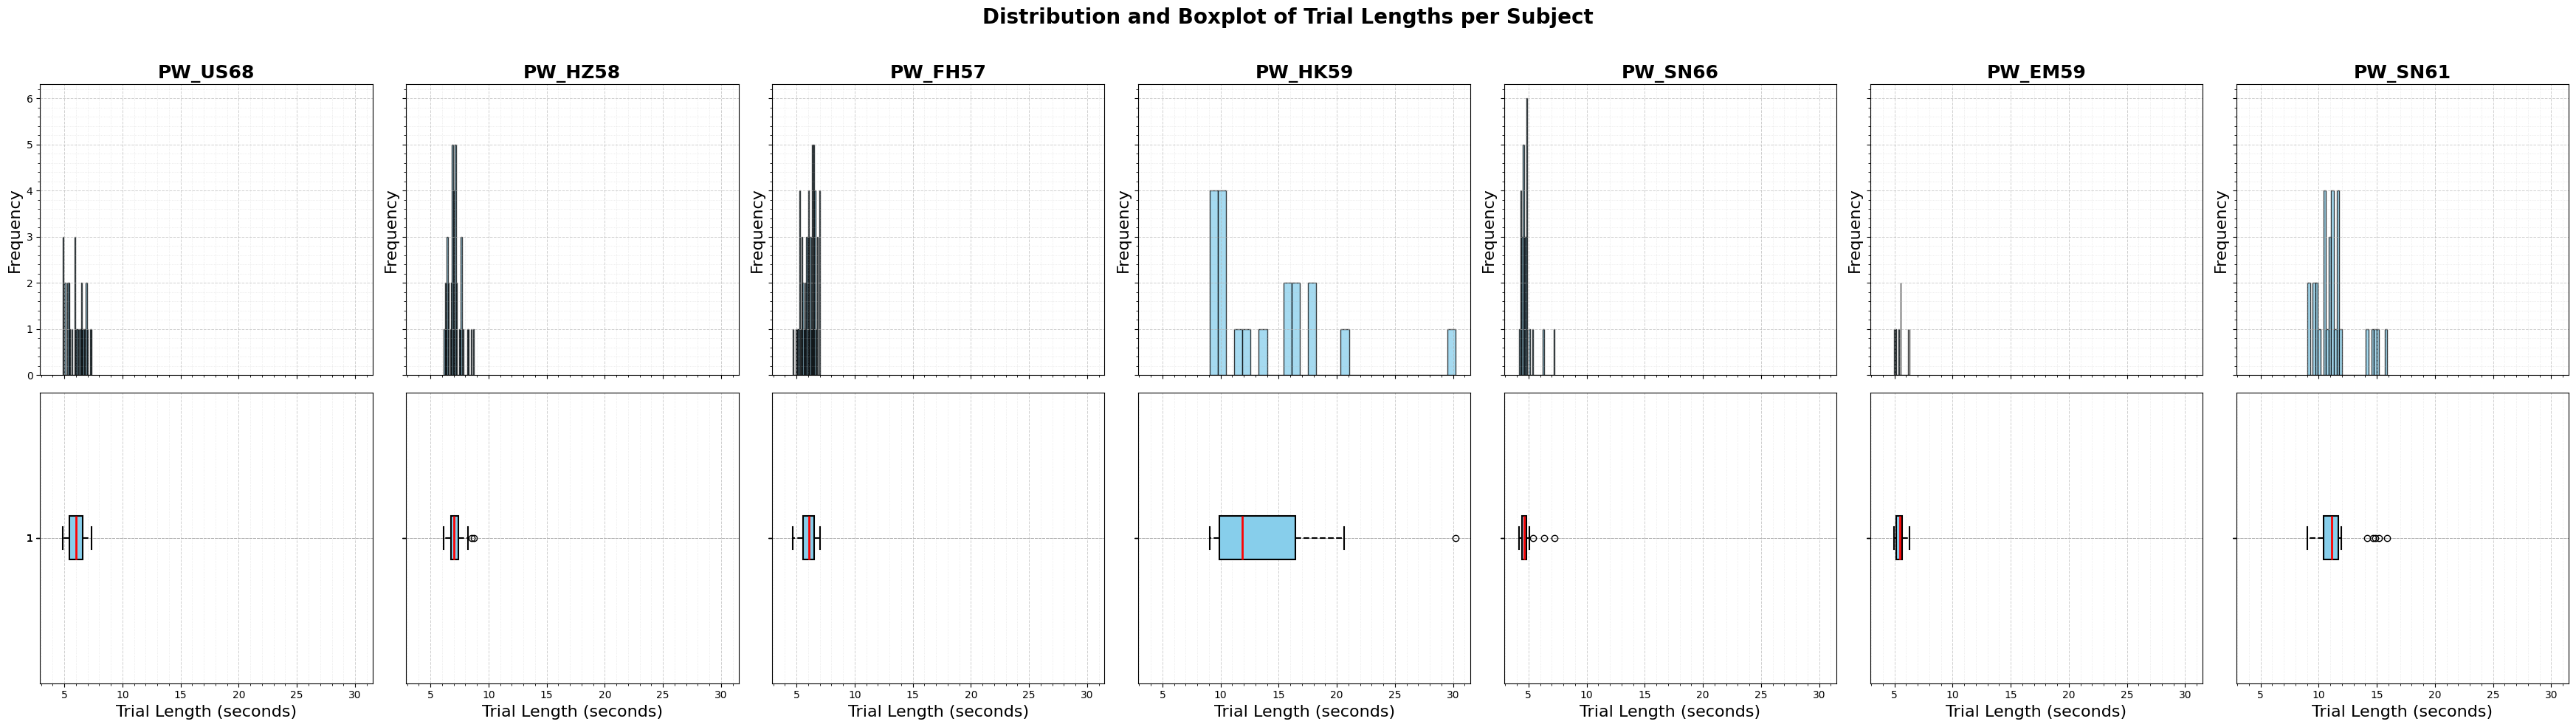

In [11]:
Visualise.plot_trial_lengths_per_subject_distr(subjects_lfp_data_dict, lfp_sfreq, fig_save_path, fig_name='trial_lengths_per_subject_distr')

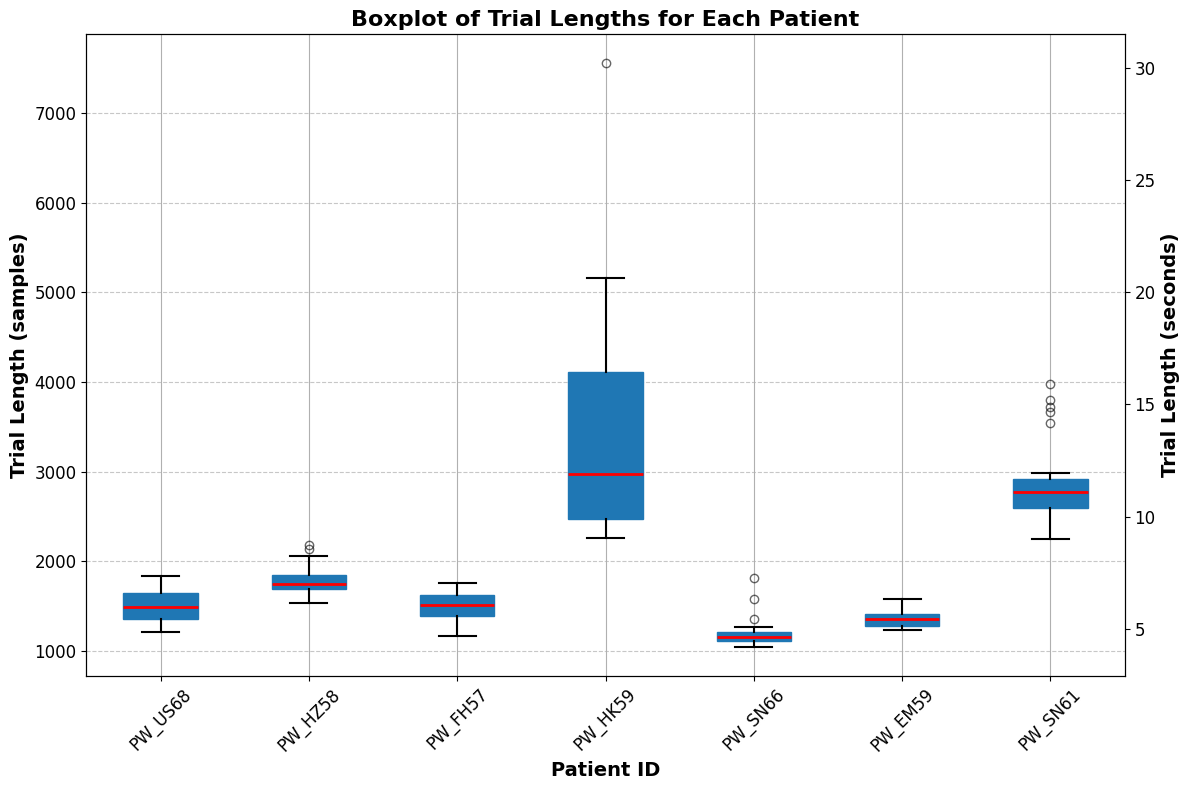

In [12]:
Visualise.plot_trial_lengths_per_subject_boxplot(subjects_lfp_data_dict, lfp_sfreq, fig_save_path, fig_name='trial_lengths_per_subject_boxplot')

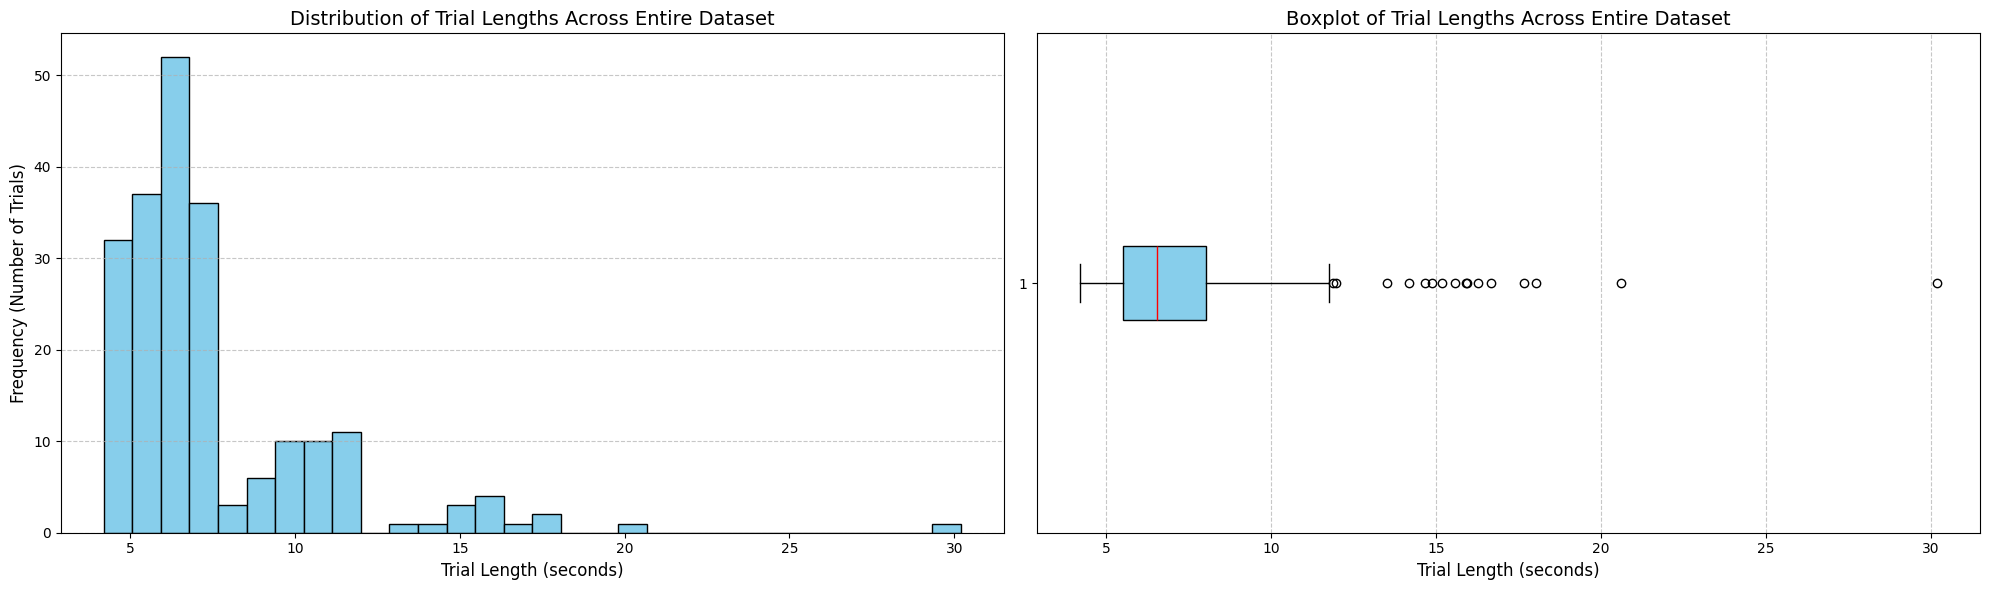

In [13]:
Visualise.plot_all_trial_lengths(subjects_lfp_data_dict, lfp_sfreq, fig_save_path, fig_name='all_trial_length_combined')

In [14]:
# Visualise().plot_all_patients_trials(
#     data=subjects_lfp_data_dict,
#     sfreq=lfp_sfreq,
#     save_path=fig_save_path,
#     fig_name='lfp_data_all_patients_trials',
#     sharex=True,
#     sharey=True,
# )

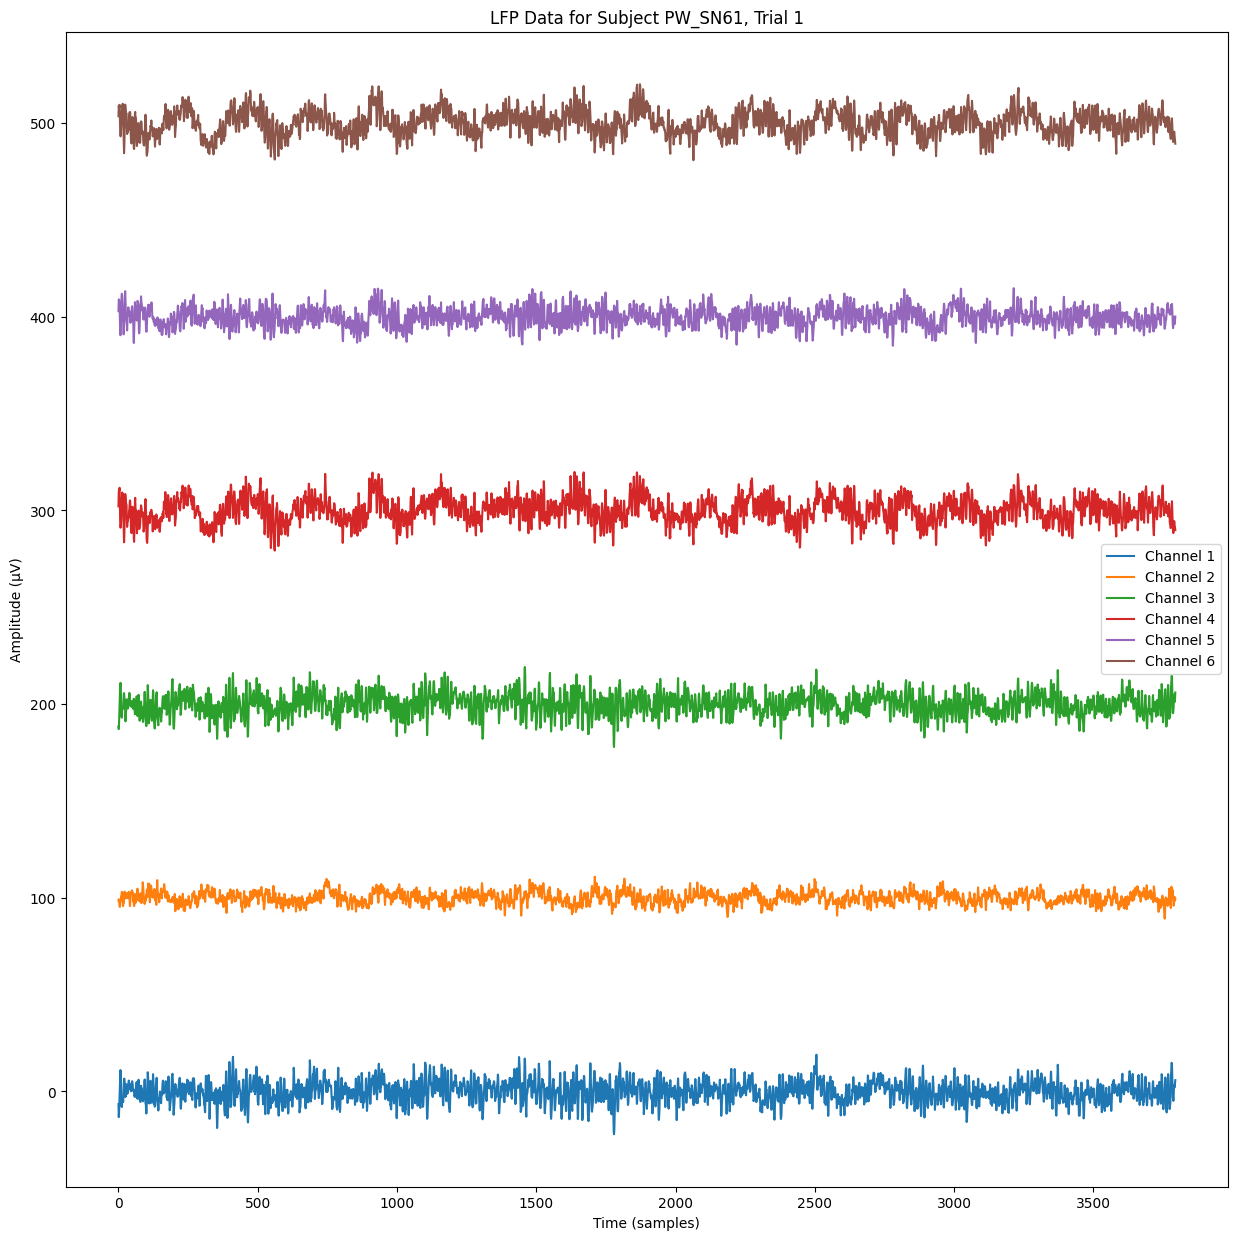

In [15]:
subject = 'PW_SN61'  # specify the subject
trial_index = 0  # specify the trial index

# Extract the data for the specified subject and trial
trial_data = subjects_lfp_data_dict[subject][trial_index]

# Plot the data
plt.figure(figsize=(15, 15))
for channel in range(trial_data.shape[0]):
    plt.plot(trial_data[channel, :] + channel * 100, label=f'Channel {channel + 1}')

plt.title(f'LFP Data for Subject {subject}, Trial {trial_index + 1}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.show()

---
# Segmentation

In [16]:
subjects_lfp_data_dict, subjects_event_idx_dict, data
subjects_lfp_data_dict['PW_EM59'][0].shape
subjects_event_idx_dict['PW_FH57']

array([[   0,  180,  303,  480,  488,  608,  788, 1365],
       [   0,  201,  283,  528,  485,  643,  738, 1240],
       [   0,  224,  383,  543,  570,  665,  768, 1315],
       [   0,  185,  293,  471,  508,  588,  965, 1395],
       [   0,  210,  210,  566,  488,  760,  840, 1465],
       [   0,  240,  268,  699,  663,  920, 1005, 1560],
       [   0,  204,  305,  539,  495,  665,  828, 1380],
       [   0,  215,  243,  542,  590,  670,  785, 1365],
       [   0,  232,  293,  526,  573,  648,  730, 1310],
       [   0,  231,  245,  572,  663,  685,  880, 1460],
       [   0,  236,  365,  561,  558,  683,  825, 1435],
       [   0,  227,  250,  440,  388,  523,  713, 1250],
       [   0,  206,  223,  480,  528,  563,  680, 1170],
       [   0,  249,  363,  629,  560,  770, 1063, 1755],
       [   0,  230,  290,  450,  443,  535,  618, 1305],
       [   0,  197,  300,  491,  465,  575,  795, 1325],
       [   0,  269,  343,  668,  568,  848,  918, 1645],
       [   0,  272,  405,  612,

In [17]:
patients = list(subjects_lfp_data_dict.keys())
patients_epochs = {}

window_size=0.5
overlap=0.5
expand_transition=0.0
 
for patient in patients:
    epochs = DataProcessor.segment_and_label_trials(
        trials=subjects_lfp_data_dict[patient],
        subjects_event_idx_dict=subjects_event_idx_dict[patient],
        ch_names=fix_chs_names,
        sfreq=lfp_sfreq,
        window_size=window_size,
        overlap=overlap,
        expand_transition=expand_transition,
        discard_ambiguous=False,
    )
    patients_epochs[patient] = epochs

Not setting metadata
658 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1057 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1307 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1043 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
516 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
165 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1337 matching events found
No baseline correction applied
0 projection items activated


/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gaitmod/gaitmod/utils/data_processor.py:637: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.EpochsArray(
/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gaitmod/gaitmod/utils/data_processor.py:648: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)
/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gaitmod/gaitmod/utils/data_processor.py:637: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.EpochsArray(
/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gaitmod/gaitmod/utils/data_processor.py:648: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_mon

In [18]:
def dummy_test_label_assignment():
    """Test segmentation and labeling for different window positions relative to modulation phase."""

    lfp_sfreq = 250  # Hz
    window_size_samples = int(0.5 * lfp_sfreq)  # 500ms window

    # Create a dummy LFP trial with arbitrary values (1 channel, 3000 samples)
    trial_data = np.zeros((1, 3000))  
    trials = [trial_data]

    # Define test cases
    test_cases = [
        # Windows shorter than modulation
        (200, 500, 0, "before modulation", 0),         # Case 1
        (200, 500, 100, "<50% start overlap", 0),      # Case 2
        (200, 500, 190, ">50% start overlap", 1),      # Case 3
        (200, 500, 250, "fully inside modulation", 1), # Case 4
        (200, 500, 400, ">50% end overlap", 1),        # Case 5
        (200, 500, 490, "<50% end overlap", 0),        # Case 6
        (200, 500, 600, "after modulation", 0),        # Case 7

        # Windows longer than modulation
        (200, 300, 0, "before modulation (long)", 0),       # Case 1
        (200, 300, 100, "<50% start overlap (long)", 0),    # Case 2
        (200, 300, 190, "fully containing modulation", 1),  # Case 3
        (200, 250, 190, "fully containing modulation", 0),  # Case 3
        (200, 300, 290, "<50% end overlap (long)", 0),      # Case 4
        (200, 300, 400, "after modulation (long)", 0)       # Case 5
    ]

    for mod_start, mod_end, window_start, description, expected_label in test_cases:
        window_end = window_start + window_size_samples

        # Calculate overlap ratio
        mod_overlap = max(0, min(window_end, mod_end) - max(window_start, mod_start))
        mod_ratio = mod_overlap / window_size_samples

        # Assign label based on >50% overlap
        predicted_label = 1 if mod_ratio > 0.5 else 0

        # Print debug info
        print(f"Test: {description} | Overlap: {mod_ratio:.2f} | Expected: {expected_label} | Predicted: {predicted_label}")

        # Assert correctness
        assert predicted_label == expected_label, f"Failed test: {description}"

# Run tests
dummy_test_label_assignment()

Test: before modulation | Overlap: 0.00 | Expected: 0 | Predicted: 0
Test: <50% start overlap | Overlap: 0.20 | Expected: 0 | Predicted: 0
Test: >50% start overlap | Overlap: 0.92 | Expected: 1 | Predicted: 1
Test: fully inside modulation | Overlap: 1.00 | Expected: 1 | Predicted: 1
Test: >50% end overlap | Overlap: 0.80 | Expected: 1 | Predicted: 1
Test: <50% end overlap | Overlap: 0.08 | Expected: 0 | Predicted: 0
Test: after modulation | Overlap: 0.00 | Expected: 0 | Predicted: 0
Test: before modulation (long) | Overlap: 0.00 | Expected: 0 | Predicted: 0
Test: <50% start overlap (long) | Overlap: 0.20 | Expected: 0 | Predicted: 0
Test: fully containing modulation | Overlap: 0.80 | Expected: 1 | Predicted: 1
Test: fully containing modulation | Overlap: 0.40 | Expected: 0 | Predicted: 0
Test: <50% end overlap (long) | Overlap: 0.08 | Expected: 0 | Predicted: 0
Test: after modulation (long) | Overlap: 0.00 | Expected: 0 | Predicted: 0


In [ ]:
epochs_with_events_path = os.path.join(fig_save_path, "epochs_with_events")
os.makedirs(epochs_with_events_path, exist_ok=True)

for patient in patients:
    Visualise.plot_epochs_with_events(patients_epochs, patient, window_size, lfp_sfreq, new_events_order, subjects_event_idx_dict, show_fig=False, save_path=epochs_with_events_path, fig_name=f'epochs_with_events_{patient}')
    print(f"Epochs with events for {patient}")


Epochs with events for PW_US68
Epochs with events for PW_HZ58
Epochs with events for PW_FH57
Epochs with events for PW_HK59
Epochs with events for PW_EM59
Epochs with events for PW_SN66
Epochs with events for PW_SN61


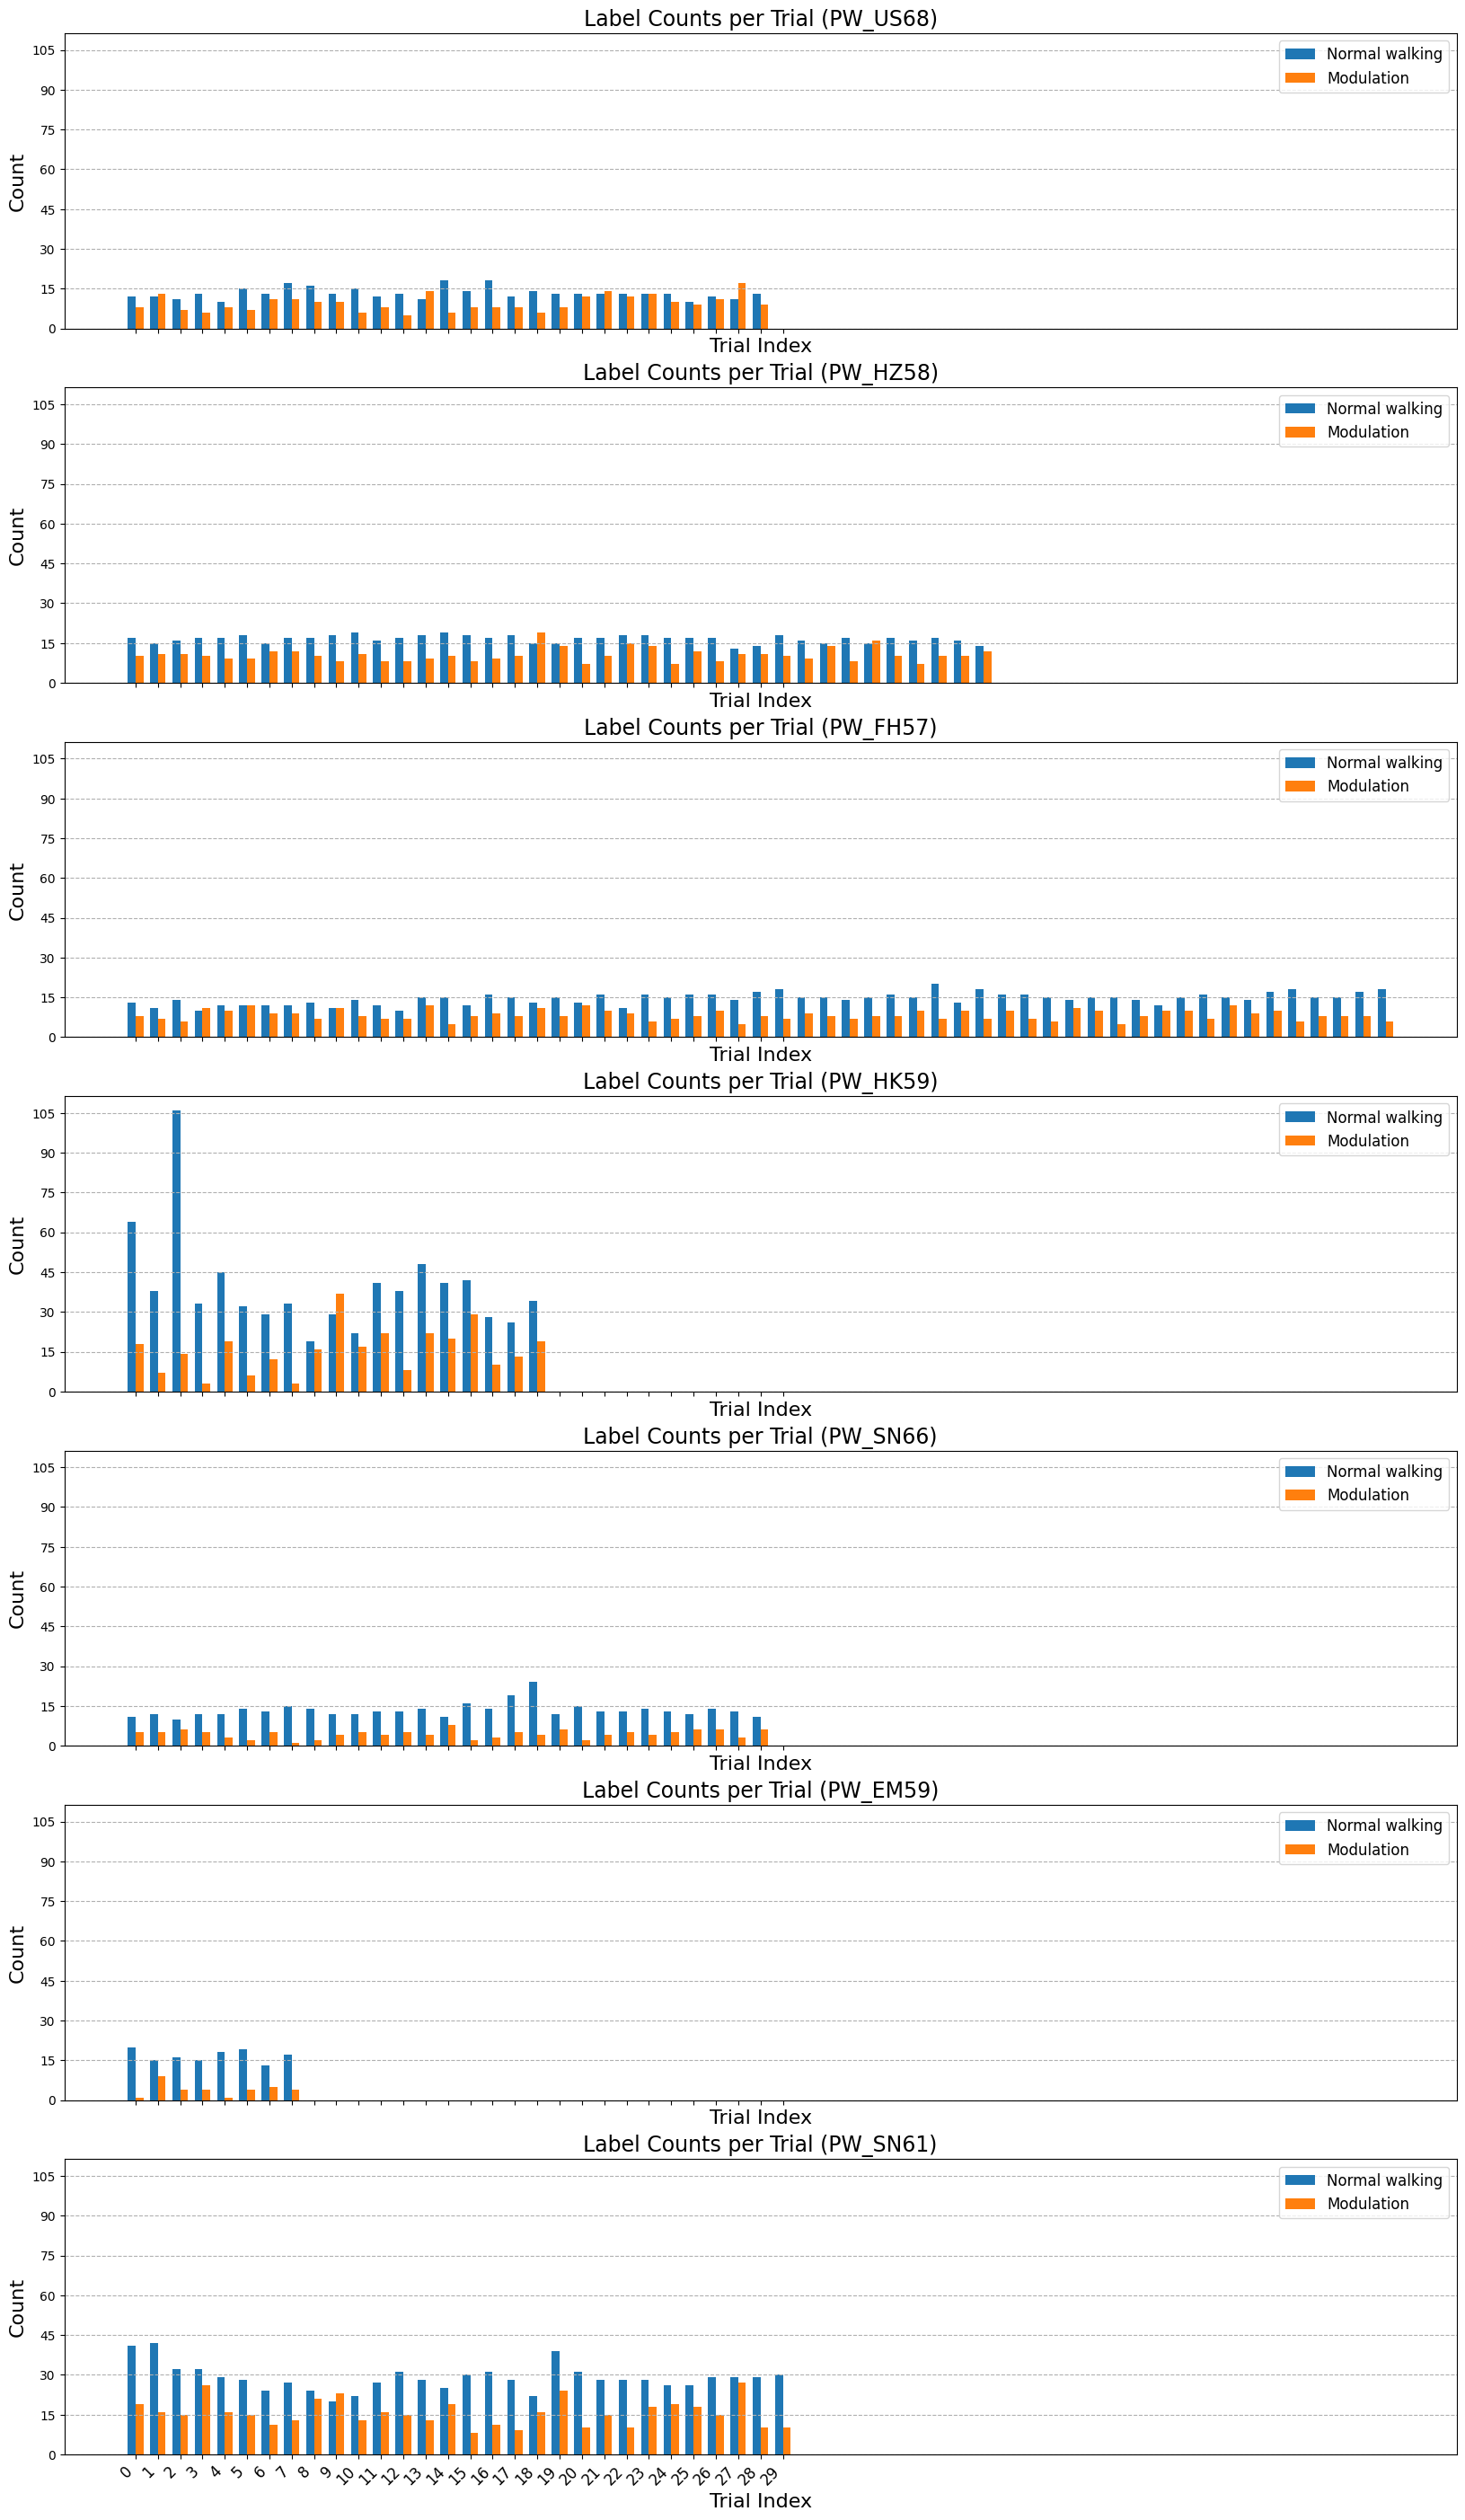

In [25]:
Visualise.plot_individual_trial_counts(patients_epochs, fig_save_path, 'individual_trial_counts')

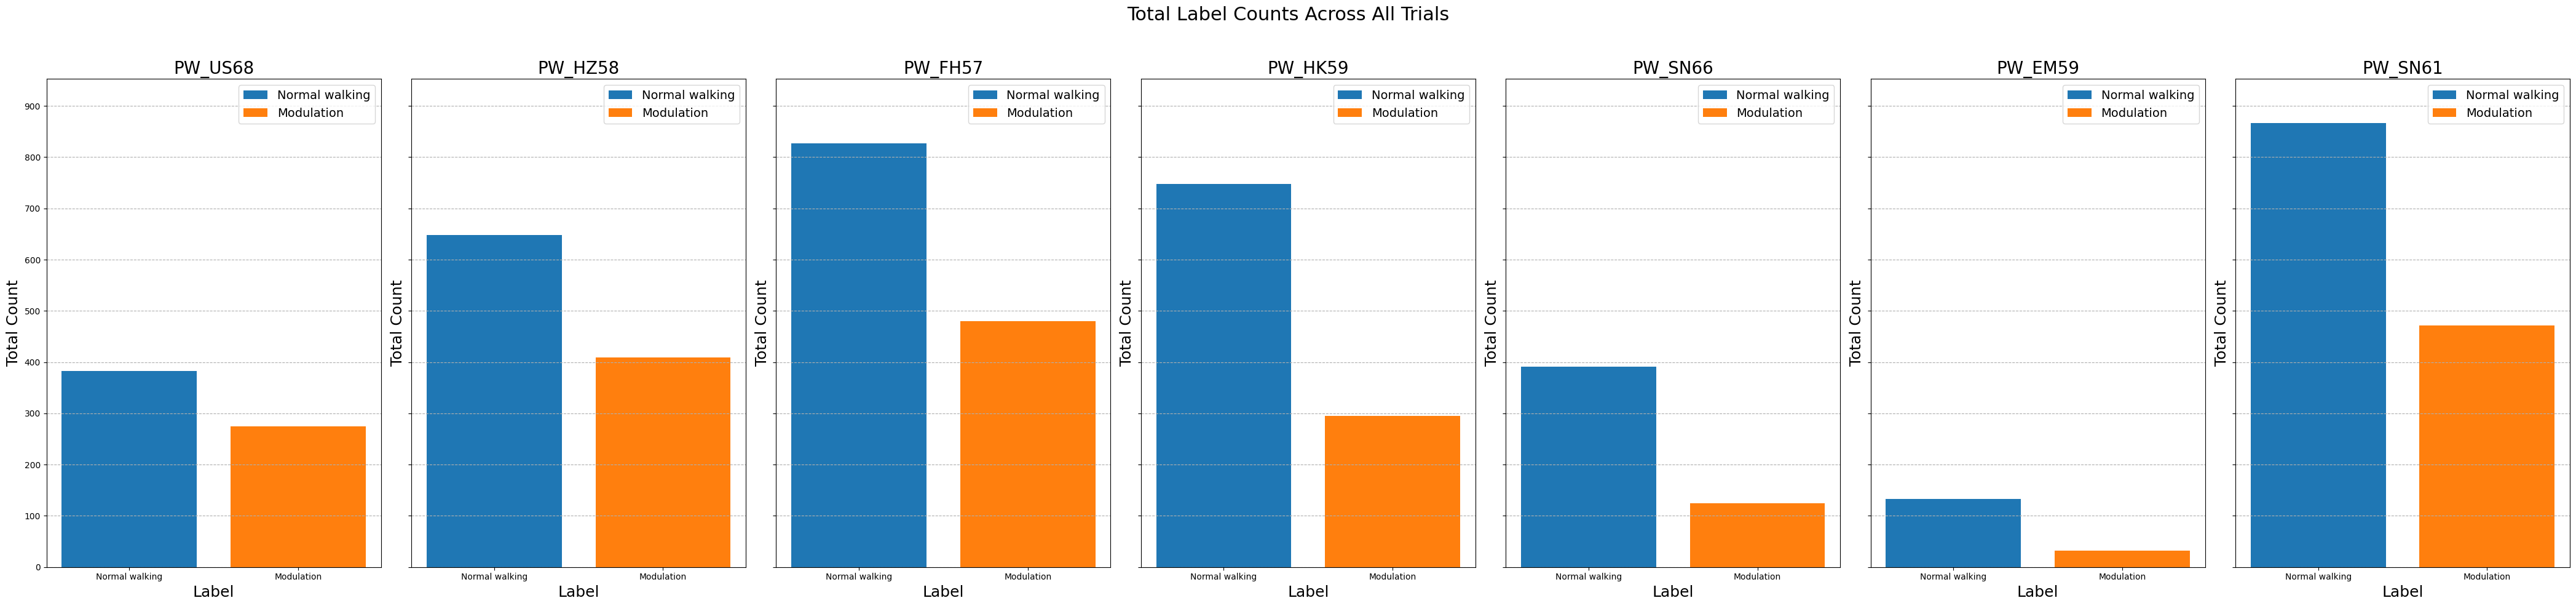

In [26]:
Visualise.plot_total_label_counts(patients_epochs, fig_save_path, 'total_label_counts')


In [27]:
# TODO: Plot epochs distribution per patient without distingushing events classes.

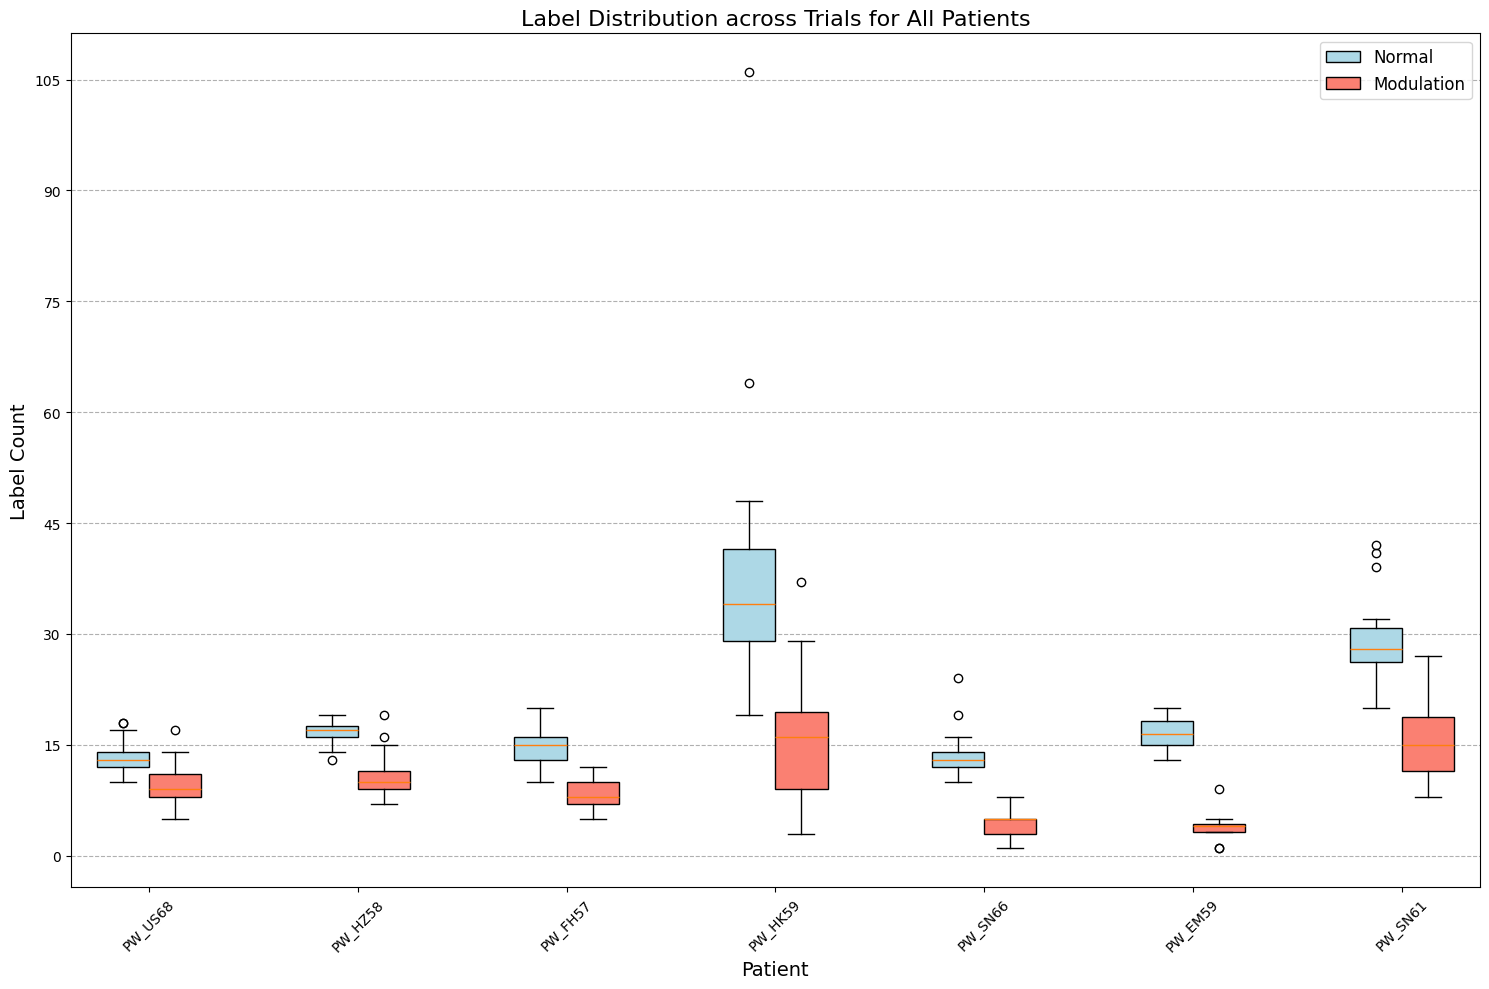

In [28]:
Visualise.plot_label_distribution_boxplot_all_patients(patients_epochs, fig_save_path, 'label_distribution_boxplot_all_patients')

# Export data

In [35]:
save_pickle(patients_epochs, 'results/pickles/patients_epochs.pickle')
save_pickle(subjects_event_idx_dict, 'results/pickles/subjects_event_idx_dict.pickle')

In [26]:
import pickle

# Define the data to be exported
export_data = {
    'feature_matrix': feature_matrix,
    'fig_save_path': fig_save_path,
    'first_data': first_data,
    'first_session': first_session,
    'first_subject': first_subject,
    'fix_chs_names': fix_chs_names,
    'key_map': key_map,
    'lfp_metadata': lfp_metadata,
    'lfp_sfreq': lfp_sfreq,
    'mat_reader': mat_reader,
    'max_trial_length': max_trial_length,
    'min_trial_length': min_trial_length,
    'n_subjects': n_subjects,
    'n_trials': n_trials,
    'n_trials_list': n_trials_list,
    'new_events_order': new_events_order,
    'patient': patient,
    'patients': patients,
    'patients_epochs': patients_epochs,
    'patients_events_array': patients_events_array,
    'root_directory': root_directory,
    'sessions': sessions,
    'subject': subject,
    'subject_id': subject_id,
    'subject_name': subject_name,
    'subjects_event_idx_dict': subjects_event_idx_dict,
    'subjects_lfp_data_dict': subjects_lfp_data_dict,
    'subjects_list': subjects_list,
    'table_data': table_data,
    'trial_data': trial_data,
    'trial_idx': trial_idx,
    'trial_index': trial_index,
    'valid_data_types': valid_data_types
}

# Save the data to a pickle file
with open('exported_data.pkl', 'wb') as f:
    pickle.dump(export_data, f)

NameError: name 'feature_matrix' is not defined

# Feature Extraction

In [ ]:



from scipy.stats import skew, kurtosis
from mne.time_frequency import psd_welch

def extract_features_from_epochs(epochs):
    """
    Extracts time-domain and frequency-domain features from MNE epochs.

    Args:
        epochs (mne.Epochs): Segmented LFP data.

    Returns:
        np.ndarray: Feature matrix (n_windows, n_features).
    """
    features = []
    sfreq = epochs.info['sfreq']
    
    for epoch in epochs.get_data():  # Shape (n_windows, n_channels, n_samples)
        epoch_features = []
        for ch in range(epoch.shape[0]):
            signal = epoch[ch]
            
            # Time-domain features
            mean_val = np.mean(signal)
            std_val = np.std(signal)
            skew_val = skew(signal)
            kurt_val = kurtosis(signal)

            # Frequency-domain features
            psd, freqs = psd_welch(epochs, picks=[ch], fmin=0.5, fmax=100, verbose=False)
            total_power = np.sum(psd)  # Total band power
            
            epoch_features.extend([mean_val, std_val, skew_val, kurt_val, total_power])
        
        features.append(epoch_features)
    
    return np.array(features)

ImportError: cannot import name 'psd_welch' from 'mne.time_frequency' (/Users/orabe/miniconda3/envs/gaitmod/lib/python3.10/site-packages/mne/time_frequency/__init__.py)

In [ ]:
import numpy as np
import mne
from scipy.stats import skew, kurtosis, median_abs_deviation
from mne.time_frequency import psd_array_multitaper

def extract_features_from_patient_epochs(epochs: mne.EpochsArray) -> np.ndarray:
    """
    Extracts time-domain and frequency-domain features from an MNE EpochsArray object of one patient.

    Args:
        epochs (mne.EpochsArray): MNE EpochsArray object containing the patient's segmented data.

    Returns:
        np.ndarray: Feature matrix of shape (n_epochs, n_features).
    """
    sfreq = epochs.info['sfreq']

    # Define frequency bands (Hz)
    freq_bands = {
        "delta": (0.1, 3),
        "theta": (4, 7),
        "alpha": (8, 12),
        "low_beta": (12, 16),
        "high_beta": (16, 30),
        "gamma": (30, 100)
    }
    
    # Get epoch data
    epochs_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    n_epochs, n_channels, n_times = epochs_data.shape

    # Initialize feature array
    feature_matrix = []

    for epoch_idx in range(n_epochs):
        epoch_data = epochs_data[epoch_idx]  # Shape: (n_channels, n_times)
        features = []

        # Time-domain features per channel
        mean_vals = np.mean(epoch_data, axis=1)  # (n_channels,)
        std_vals = np.std(epoch_data, axis=1)  # (n_channels,)
        median_vals = np.median(epoch_data, axis=1)  # (n_channels,)
        mad_vals = median_abs_deviation(epoch_data, axis=1)  # (n_channels,)
        skew_vals = skew(epoch_data, axis=1, nan_policy='omit')  # (n_channels,)
        # kurt_vals = kurtosis(epoch_data, axis=1, nan_policy='omit')  # (n_channels,)

        # Frequency-domain features (psd: n_channels x n_freqs)
        psd, freqs = psd_array_multitaper(epoch_data, sfreq, fmin=0.1, fmax=100, adaptive=True, normalization='full')

        band_power = []
        for _, (fmin, fmax) in freq_bands.items():
            band_idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
            band_power.append(np.mean(psd[:, band_idx], axis=1))  # Mean power in the band

        band_power = np.concatenate(band_power, axis=0)  # Flatten band power features

        # Combine all features
        features.extend(mean_vals)
        features.extend(std_vals)
        features.extend(median_vals)
        features.extend(mad_vals)
        features.extend(skew_vals)
        # features.extend(kurt_vals)
        features.extend(band_power)

        feature_matrix.append(features)

    return np.array(feature_matrix)  # Shape: (n_epochs, n_features)

feature_matrix = extract_features_from_patient_epochs(patients_epochs['PW_SN61'])

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_7588/4084049062.py:29: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

In [ ]:
import numpy as np
import scipy.stats as stats
import mne

def extract_features_from_epochs(
    epochs: mne.Epochs, 
    feature_handling: str = "flatten"
) -> np.ndarray:
    """
    Extracts statistical and spectral features from an MNE Epochs object.

    Args:
        epochs (mne.Epochs): The input MNE Epochs object containing LFP signals.
        feature_handling (str): Strategy for handling multiple channels.
            - "flatten": Concatenates features across channels into a single vector.
            - "average": Averages feature values across all channels.
            - "separate": Keeps channels as a separate axis (for deep learning).

    Returns:
        np.ndarray: Extracted feature matrix with shape depending on `feature_handling`:
            - "flatten": (n_epochs, n_features * n_channels)
            - "average": (n_epochs, n_features)
            - "separate": (n_epochs, n_channels, n_features_per_channel)
    """
    
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_samples)
    n_epochs, n_channels, n_samples = data.shape
    
    # Compute time-domain features (expand last dimension to match band_power)
    mean_vals = np.mean(data, axis=2, keepdims=True)      # (n_epochs, n_channels, 1)
    std_vals = np.std(data, axis=2, keepdims=True)        # (n_epochs, n_channels, 1)
    median_vals = np.median(data, axis=2, keepdims=True)  # (n_epochs, n_channels, 1)
    mad_vals = np.mean(np.abs(data - np.median(data, axis=2, keepdims=True)), axis=2, keepdims=True)  # (n_epochs, n_channels, 1)
    skew_vals = stats.skew(data, axis=2, keepdims=True)   # (n_epochs, n_channels, 1)
    kurt_vals = stats.kurtosis(data, axis=2, keepdims=True)  # (n_epochs, n_channels, 1)
    
    # Compute band power for predefined frequency bands
    bands = [(0.1, 3), (4, 7), (8, 12), (12, 16), (16, 20), (20, 30), (30, 100), (100, 250)]
    psd, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=epochs.info['sfreq'], fmin=0.1, fmax=250, verbose=False)
    band_power = np.array([
        np.sum(psd[:, :, (freqs >= fmin) & (freqs <= fmax)], axis=2, keepdims=True)
        for fmin, fmax in bands
    ])  # Shape: (n_bands, n_epochs, n_channels, 1)
    band_power = np.transpose(band_power, (1, 2, 0, 3))  # (n_epochs, n_channels, n_bands, 1)
    band_power = band_power.squeeze(-1)  # Remove last dimension -> (n_epochs, n_channels, n_bands)

    # Combine all features
    feature_list = [mean_vals, std_vals, median_vals, mad_vals, skew_vals, kurt_vals, band_power]
    feature_matrix = np.concatenate(feature_list, axis=2)  # (n_epochs, n_channels, n_features_per_channel)
    
    # Handle different feature structures
    if feature_handling == "flatten":
        return feature_matrix.reshape(n_epochs, -1)  # (n_epochs, n_features * n_channels)
    elif feature_handling == "average":
        return np.mean(feature_matrix, axis=1)  # (n_epochs, n_features)
    elif feature_handling == "separate":
        return feature_matrix  # (n_epochs, n_channels, n_features_per_channel)
    else:
        raise ValueError("Invalid feature_handling mode. Choose from ['flatten', 'average', 'separate'].")

# feature_handling:
# seperate: (n_epochs, n_channels, n_features_per_channel)
# flatten: (n_epochs, n_features * n_channels)
# average: (n_epochs, n_features)

feature_handling = "seperate"    
feature_matrix = extract_features_from_epochs(patients_epochs['PW_EM59'], feature_handling)

feature_matrix.shape

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_9598/2293705519.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_samples)


(165, 6, 14)

In [ ]:
# patients_epochs['PW_FH57'].get_data().shape
feature_matrix.shape

(1337, 66)

In [ ]:
# Load LFP parameters
lfp_ch_names = DataProcessor.rename_lfp_channels(lfp_metadata['labels'])
lfp_n_channels = lfp_metadata['NumberOfChannels']

info = mne.create_info(ch_names=lfp_ch_names, sfreq=lfp_sfreq, ch_types='dbs', verbose=40)

# Define normal walking events and mod_start
event_of_interest = config['events']['event_of_interest']
other_events = config['events']['other_events']

mod_start_event_id = config['events']['mod_start_event_id']
normal_walking_event_id = config['events']['normal_walking_event_id']

# Define the event dictionary
event_dict = {
    event_of_interest: mod_start_event_id,
    other_events: normal_walking_event_id
}

# Segmentation parameters
epoch_tmin = config['segmentation']['epoch_tmin']
epoch_tmax = config['segmentation']['epoch_tmax']
epoch_duration = epoch_tmax - epoch_tmin

epoch_sample_length = int(epoch_duration * lfp_sfreq)
gap_duration = config['segmentation']['gap_duration']
gap_sample_length = int(gap_duration * lfp_sfreq)

reject_criteria = {'dbs': float(config['reject_criteria']['dbs_threshold'])}

In [ ]:
Visualise.plot_raw_data_with_annotations(
    lfp_raw_list, scaling=5e1, folder_path='images/raw')

In [ ]:
# save all lfp data
with open('processed/all_lfp_data.pkl', 'wb') as f:
    pickle.dump(all_lfp_data, f)
    
with open('processed/lfp_raw_list.pkl', 'wb') as f:
    pickle.dump(lfp_raw_list, f)
    
# save epoched data
epochs.save(f"processed/lfp_{epoch_tmin}tmin_{gap_duration}gap-epo.fif", overwrite=True)
    

In [ ]:
Visualise.plot_event_occurrence(events=events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/event_classes.png')


Visualise.plot_event_occurrence(events=epochs.events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/epochs.event_classes.png')

In [ ]:
Visualise.plot_event_class_histogram(events=events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/event_class_histogram.png')

Visualise.plot_event_class_histogram(events=epochs.events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/epochs.event_class_histogram.png')